#[PyTorch Tutorial](https://pytorch.org/tutorials/index.html)

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

from tqdm.notebook import tqdm

## 1. Load and normalizing the datasets using torchvision

The output of torchvision datasets are PILImage images of range [0, 1].



In [ ]:
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                         shuffle=False, num_workers=8)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid poten

## 2. Define a Convolution Neural Network



**굵은 텍스트**##### Net w/ Dropout

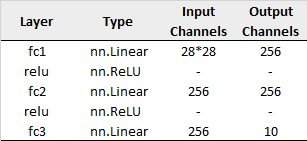

In [ ]:
class Net_with_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(Net_with_dropout, self).__init__()

        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256,10)
        self.relu = nn.ReLU()
        
        self.dropout = nn.Dropout(0.2)
    def forward(self, x):
        
        # B x 1 x H(28) x W(28)
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        out = self.fc3(x)

        return out

##### Net w/o Dropout
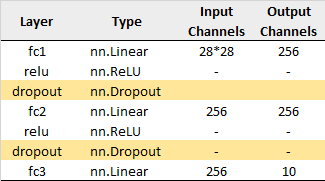

In [ ]:
class Net_without_dropout(nn.Module):
    def __init__(self, num_classes=10):
        super(Net_without_dropout, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256,10)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        
        # B x 1 x H(28) x W(28)
        
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        out = self.fc3(x)

        return out

In [ ]:
net = Net_with_dropout()
#net = Net_without_dropout()
net = net.cuda()

## 3. Define a Loss function and optimizer

Let's use a Classification Cross-Entropy loss and SGD with momentum.



In [ ]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1)

## 4. Train the network

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



In [ ]:
import time

epochs = 15

for epoch in range(epochs):  # loop over the dataset multiple times

    net.train()

    running_loss = 0.0
    start = time.time()

    correct = 0
    total = 0
    for i, data in enumerate(tqdm(trainloader)):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        B, _, H, W = inputs.shape
        inputs = inputs.view(B, H*W)

        # forward + backward + optimize
        outputs = net(inputs)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()

    end = time.time()
    print('(Train) [epoch : %d] loss: %.3f / time: %.3f / acc@1: %.3f' %
          (epoch + 1, running_loss / len(trainloader), (end-start), 100 * correct / total))

    net.eval()

    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()

            B, _, H, W = inputs.shape
            inputs = inputs.view(B, H*W)

            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('(Test) Accuracy of the network on the 10000 test images: %.3f %%\n' % (
        100 * correct / total))

print('Finished Training')

  0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


(Train) [epoch : 1] loss: 0.761 / time: 18.573 / acc@1: 74.717


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 84.540 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 2] loss: 0.353 / time: 18.946 / acc@1: 88.597


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 90.290 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 3] loss: 0.248 / time: 18.944 / acc@1: 92.205


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 92.770 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 4] loss: 0.203 / time: 18.780 / acc@1: 93.537


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 94.480 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 5] loss: 0.174 / time: 18.993 / acc@1: 94.463


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 94.250 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 6] loss: 0.152 / time: 18.808 / acc@1: 95.197


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 94.760 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 7] loss: 0.139 / time: 19.004 / acc@1: 95.587


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.380 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 8] loss: 0.125 / time: 18.951 / acc@1: 95.967


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.690 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 9] loss: 0.117 / time: 18.860 / acc@1: 96.228


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.780 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 10] loss: 0.104 / time: 19.127 / acc@1: 96.700


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.980 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 11] loss: 0.095 / time: 19.254 / acc@1: 96.947


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 95.880 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 12] loss: 0.092 / time: 19.179 / acc@1: 97.047


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 96.370 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 13] loss: 0.083 / time: 19.158 / acc@1: 97.293


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 96.690 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 14] loss: 0.078 / time: 19.164 / acc@1: 97.457


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 96.380 %



  0%|          | 0/469 [00:00<?, ?it/s]

(Train) [epoch : 15] loss: 0.074 / time: 19.226 / acc@1: 97.588


  0%|          | 0/79 [00:00<?, ?it/s]

(Test) Accuracy of the network on the 10000 test images: 96.210 %

Finished Training
